In [40]:
import numpy as np
import numpy.linalg as lin
import numpy.random as rand
import pandas as pd
import argparse
from sklearn.datasets import load_breast_cancer, fetch_covtype, load_svmlight_file
from sklearn.linear_model import ridge_regression
import random as rand
from numpy import linalg as LA
import matplotlib.pyplot as plt

def project( theta ):
    """
    This function does a projection on the ball with norm 1000 for the variable theta
    :param theta: the vector which we wish to use for projection
    :return: the projected vector
    """
    Norm = theta.dot(theta)

    if (Norm >= 1000): theta = theta / Norm

    return theta


def prefix_grad(X, y , theta, i , lambda_reg):
    """
    This function calculates the gradient for the prefix of the input sequence, up until
    index i
    :param X: the feature vector including at least all the features of the prefix until i
    :param y: the label vector including at least all the labels of the prefix until i
    :param theta: the current parameter vector
    :param i: the last node that belongs to the prefix
    :param lambda_reg: the regularization parameter
    :return: the gradient of the prefix
    """
    res = np.zeros(theta.shape)

    for j in range(i+1):

        res = res + (np.dot(X[j],theta) - y[j]) * X[j]

    res = res / (i+1) + lambda_reg * theta

    return res


def Prefix_F (theta, X, y, k, lambda_reg):
    """
    This function calculates the value of the prefix sum of the sequence up until index k
    :param theta: the current parameter vector
    :param X: the feature vector including at least all the features of the prefix until k
    :param y: the label vector including at least all the labels of the prefix until k
    :param k: the last sample that belongs to the prefix
    :param lambda_reg: the regularization parameter
    :return: the value of the prefix sum
    """
    res = 0

    for j in range(k+1):

        res = res + 0.5 * (y[j] - theta.dot(X[j]))**2

    res = res / (k+1)

    res = res + 0.5 * lambda_reg * (theta.dot(theta))
    return res

def sequential_linear_regression(X, Y, lmda):
    """
    This function is used to calculate the optimal function values for linear regression with regularization
    of the prefix sum for all prefixes of the sequence of X
    :param X: The feature vector of the entire sequence
    :param Y: The label vector of the entire sequence
    :lmda: The regularization parameter
    :return: A list with the optimal function values for all the prefixes of the sequence
    """
    x_star_lst = []

    A = 0

    b = 0

    n = 0

    for (x, y) in zip(X, Y):

        dim = len(x)

        A = A + np.outer(x, x)

        b = b + y*x

        n += 1

        coef = np.linalg.solve((1/n) * A + lmda*np.eye(dim), b * (1/n))

        x_star_lst.append(np.array(coef))

    f_star_lst = [ Prefix_F(u, X, Y, k, lmda) for k,u in enumerate(x_star_lst) ]

    return f_star_lst

In [41]:
def GD(X, y, x0, learning_rate, T, k, lambda_reg):
    """
    This function does gradient descent for T iterations for the first k samples
    :param X: the feature vector including at least all the features of the prefix until k
    :param y: the label vector including at least all the labels of the prefix until k
    :param x0: the intialization for the parameter vector
    :param learning_rate: the learning rate that will be used for the gradient steps
    :param T: the number of gradient steps that the function does
    :param k: the last sample that belongs to the prefix
    :param lambda_reg: the regularization parameter
    :return: Returns an optimized parameter vector
    """
    theta = x0

    fvalues = []

    for t in range(T):

        nabla = prefix_grad(X, y, theta, k, lambda_reg)

        theta = project(theta  - learning_rate * nabla)

        fvalues.append(Prefix_F(theta, X, y, k, lambda_reg))

    return theta , fvalues

def Produce_GD(X, y, lambda_reg, T, L):
    """
    This function executes gradient descent as a solver for the instance optimal setting
    :param X: the feature vector for the whole sequence
    :param y: the label vector for the whole sequence
    :param lambda_reg: the regularization parameter
    :param T: the iterations of gradient descent to be done at each stage of the algorithm
    :param L: the smoothness parameter for the problem
    :return: Returns the function values for the point calculated by GD for each stage of the algorithm, as well as the FOs done
    """
    x0 = np.zeros_like(X[0])
    Res = []
    FOs = []
    crFOs = 0
    for n in range(len(X)):
      x0,fvalues = GD(X, y, np.zeros_like(X[0]), 1/(2*L), T, n, lambda_reg)
      crFOs = crFOs + T*(n+1)
      FOs.append(crFOs)
      Res.append(Prefix_F(x0,X,y,n, lambda_reg))
    return Res,FOs

In [42]:
def SVRG(X, y, lambda_reg, S, gamma, m, k, x0 ):
    """
    This function implements the SVRG algorithm
    :param X: the feature vector including at least all the features of the prefix until k
    :param y: the label vector including at least all the labels of the prefix until k
    :param lambda_reg: the regularization parameter
    :param S: the outer loop iterations of the SVRG algorithm that the code should execute
    :param gamma: the learning rate to be used in the step of the algorithm
    :param m: the inner loop iterations of the Svrg algorithm that the code executes
    :param k: the prefix of the samples for which we should execute SVRG
    :param x0: the initialization vector
    :return: the optimized parameter vector for the prefix k as calculated by SVRG
    """
    xs = x0
    xm = x0
    fvalues = []
    b = m
    for s in range(S):
      fvalues.append(Prefix_F(xs, X, y, k, lambda_reg))
      nabla = prefix_grad(X,y,xs,k,lambda_reg)
      acc = 0
      for j in range(b):
        r = rand.randint(0,k)
        nabla_m = (np.dot(X[r],xm)-y[r]) * X[r] + lambda_reg * xm
        nabla_s = (np.dot(X[r],xs)-y[r]) * X[r] + lambda_reg * xs
        xm = project(xm - gamma*(nabla_m-nabla_s+nabla))
        acc= acc + xm
      xs = acc/b
      xm = xs
    return xs, fvalues

def Produce_SVRG(X, y, lambda_reg, S, gamma, m):
    """
    This function executes SVRG as a solver for the instance optimal problem
    :param X: the feature vector for the whole sequence
    :param y: the label vector for the whole sequence
    :param lambda_reg: the regularization parameter
    :param S: the outer loop iterations of the SVRG algorithm that the code should execute
    :param gamma: the learning rate to be used in the step of the algorithm
    :param m: the inner loop iterations of the Svrg algorithm that the code executes
    :return: Returns the function values for the point calculated by SVRG for each stage of the algorithm, as well as the FOs done
    """
    x0 = np.zeros_like(X[0])
    Res = []
    FOs = []
    crFOs = 0
    for n in range(len(X)):
      x0,fvalues = SVRG(X,y, lambda_reg, S, gamma, m, n, np.zeros_like(X[0]))
      crFOs = crFOs + S*(n+1) + S*m*2
      FOs.append(crFOs)
      Res.append(Prefix_F(x0,X,y,n, lambda_reg))
    return Res,FOs

In [43]:
def Katyusha(X, y, x0, n, lambda_reg, S,T_in ,sigma, L, gamma):
    """
    This function implements the Katyusha algorithm
    :param X: the feature vector including at least all the features of the prefix until n
    :param y: the label vector including at least all the labels of the prefix until n
    :param x0: the initialization vector
    :param n: the prefix of the samples for which we should execute Katyusha
    :param lambda_reg: the regularization parameter
    :param S: the outer loop iterations of the katyusha algorithm that the code should execute
    :param m: the inner loop iterations of the katyusha algorithm that the code executes
    :param sigma: the strong convexity parameter for the setting
    :param L: the smoothness parameter for the setting
    :param gamma: the learning rate to be used in the step of the algorithm
    :return: the optimized parameter vector for the prefix k as calculated by katyusha
    """
    fvalues = []
    fvalues.append( Prefix_F (x0, X, y, n, lambda_reg) )
    m = T_in
    t2 = 0.5
    t1 = min(np.sqrt((m*sigma)/(3*L)),0.5)
    alpha = 1/( 3* t1 *L )
    xs = x0
    ym = xs
    zm = ym
    xm = xs
    for s in range(S):
        nabla = prefix_grad(X,y,xs,n,lambda_reg)
        nom = np.zeros_like(X[0])
        denom = 0
        mul = 1
        for j in range(m):
            k = s * m + j
            xm = t1 * zm + t2 * xs + (1-t1-t2) * ym
            r = rand.randint(0,n)
            nabla_m = (np.dot(X[r],xm)-y[r]) * X[r] + lambda_reg * xm
            nabla_s = (np.dot(X[r],xs)-y[r]) * X[r] + lambda_reg * xs
            grad = nabla + nabla_m - nabla_s
            zm = project(zm - alpha * grad)
            ym = project(xm - grad * gamma)
            nom = nom + mul * ym
            denom = denom + mul
            mul = mul * (1+alpha*sigma)
        xs = nom/denom
        fvalues.append( Prefix_F (xs, X, y, n, lambda_reg) )
    return xs , fvalues

def Produce_Katyusha(X,y,lambda_reg, S,T_in, L, gamma):
    """
    This function executes katyusha as a solver for the instance optimal problem
    :param X: the feature vector for the whole sequence
    :param y: the label vector for the whole sequence
    :param lambda_reg: the regularization parameter
    :param S: the outer loop iterations of the katyusha algorithm that the code should execute
    :param T_in: the inner loop iterations of the katyusha algorithm that the code executes
    :param L: the smoothness parameter for the setting
    :param gamma: the learning rate to be used in the step of the algorithm
    :return: Returns the function values for the point calculated by katyusha for each stage of the algorithm, as well as the FOs done
    """
    xe = np.zeros_like(X[0])
    Res = []
    FOs = []
    crFOs = 0
    for n in range(len(X)):
        xe , _ = Katyusha(X,y,project(np.ones_like(X[0])),n ,lambda_reg, S,T_in, lambda_reg, L, gamma)
        crFOs = crFOs + S*(n+1)+T_in*S*2
        FOs.append(crFOs)
        Res.append(Prefix_F(xe, X, y, n, lambda_reg))
    return Res, FOs

In [44]:
def SGD(X, y, lambda_reg , T , k , theta_0):
    """
    This function implements the SGD algorithm
    :param X: the feature vector including at least all the features of the prefix until k
    :param y: the label vector including at least all the labels of the prefix until k
    :param lambda_reg: the regularization parameter
    :param T: the number of iterations for which the algorithm should be executed
    :param k: the last sample of the prefix which is included
    :theta_0 the initialization vector
    :return: the optimized parameter vector for the prefix k as calculated by SGD
    """
    theta = theta_0

    fvalues = []

    Avg = np.zeros_like(X[0])

    for t in range( T ):

        j = rand.randint(0,k)

        nabla = (np.dot(X[j],theta)-y[j]) * X[j] + lambda_reg * theta

        gamma = 1 / ((t+1) * lambda_reg )

        theta = project(theta  - gamma * nabla)

        Avg = Avg * (1 - 1/(t+1)) + theta / (t+1)

    return Avg, fvalues

def Produce_SGD(X, y, lambda_reg, T_in):
    """
    This function executes SGD as a solver for the instance optimal problem
    :param X: the feature vector for the whole sequence
    :param y: the label vector for the whole sequence
    :param lambda_reg: the regularization parameter
    :param T_in: the number of iterations that the SGD algorithm will be executed for every stage
    :return: Returns the function values for the point calculated by SGD for each stage of the algorithm, as well as the FOs done
    """
    Res = []

    FOs = []
    crFOs = 0

    theta_prev = np.ones_like(X[0])

    for k in range( len(X)):
        theta, fvalues  = SGD( X , y , lambda_reg , T_in , k, theta_prev)

        theta_prev = theta
        crFOs = crFOs+T_in
        FOs.append(crFOs)

        Res.append( Prefix_F( theta, X , y , k , lambda_reg ))

    return Res, FOs

def sparse_SGD(X, y, lambda_reg, A):
    """
    This function executes SGD as a solver for the instance optimal problem
    :param X: the feature vector for the whole sequence
    :param y: the label vector for the whole sequence
    :param lambda_reg: the regularization parameter
    :param A: the number of iterations T/(alpha)=A and T^2 = A, where T is the number of iterations that the algorithm executes when doing SGD
              and alpha is the sparsity of the SGD executions as described in the paper
    :return: Returns the function values for the point calculated by sparseSGD for each stage of the algorithm, as well as the FOs done
    """
    Res = []

    FOs = []

    prev = 0

    calls = 0

    crFOs = 0

    T_in = int(np.sqrt(A))

    a = 1/np.sqrt(A)

    theta_prev = np.ones_like(X[0])

    for k in range( len(X)):
      if prev*(1+a) < k:
        calls = calls +1
        theta_prev,_ = SGD( X , y , lambda_reg , T_in, k, theta_prev)
        crFOs = crFOs + T_in
        prev = k

      FOs.append(crFOs)
      Res.append(Prefix_F( theta_prev, X , y , k , lambda_reg ))
    return Res,FOs

In [45]:
def FUM(X , y , lambda_reg , i , T_in,  theta_prev , theta_i_minus_one , nabla_tilde):
    """
    This function implemnts the FUM section of the SIOPT algorithm
    :param X: the feature vector including at least all the features of the prefix until i
    :param y: the label vector including at least all the labels of the prefix until i
    :param lambda_reg: the regularization parameter
    :param i: the last sample to be included in the prefix
    :param T_in: the number of iterations for which the method should be executed
    :param theta_prev: the point where we did a previous full gradient computation
    :param theta_i_minus_one: the starting point for the method
    :param nabla_tilde: the full gradient at point theta_prev
    :return: the point calculated for prefix i
    """
    theta = theta_i_minus_one

    fvalues = []

    Avg = theta_i_minus_one

    G = 1

    for t in range( T_in ):

        j = rand.randint(0,i)

        grad_j = (np.dot(X[j],theta)-y[j]) * X[j]+ lambda_reg*theta

        grad_prev = (np.dot(X[j],theta_prev)-y[j]) * X[j] + lambda_reg*theta_prev

        grad_i = (np.dot(X[i],theta)-y[i]) * X[i]+ lambda_reg*theta

        grad = (1 - 1/i) * (grad_j - grad_prev + nabla_tilde) + grad_i / i

        G = G + grad.dot(grad)

        gamma = 1 / ((lambda_reg * (t+1) * (i+1)))

        theta = project (theta - gamma * grad)

        Avg = Avg * (1 - 1/(t+1)) + theta / (t+1)


    return Avg


def SIOPT(X , y , lambda_reg, T_in,  alpha ):
    """
    This function implements the SIOPT-grad algorithm for the instance optimal setting
    param X: the feature vector for the whole sequence
    :param y: the label vector for the whole sequence
    :param lambda_reg: the regularization parameter
    :param T_in: the number of iterations to do at each stage of the algorithm
    :param alpha: the sparsity of the sequence of full gradient computations
    :return: Returns the function values for the point calculated by SIOPT for each stage of the algorithm, as well as the FOs done
    """
    Res = []

    FOs = []

    crFOs = 0

    x_zero = np.zeros_like(X[0])

    Gditer = min(10,len(X))

    for i in range( 0 , Gditer ):

        X0 = X[:i+1]

        L = np.linalg.norm( X0.T@X0/len(X0) + lambda_reg * np.eye(len(X[0]) ), ord=2)

        x_zero,_  = GD(X, y, x_zero, 1/(2*L) , 10 , i , lambda_reg )

        Res.append( x_zero )

        crFOs = crFOs + 10*(i+1)
        FOs.append( crFOs )

    prev = 0

    update = False


    for i in range(10, len(X)):

        if ( i - prev >= alpha * i):

            nabla_tilde = prefix_grad(X, y , Res[i-1] , i - 1, lambda_reg)

            prev = i - 1

            crFOs = crFOs + i

            update = True

        Res.append( FUM(X , y , lambda_reg , i , T_in,  Res[prev] , Res[i-1] , nabla_tilde) ) #Add the new point
        crFOs = crFOs + 3*T_in

        if update:

            nabla_tilde = prefix_grad(X, y , Res[i] , i , lambda_reg) # Full gradient until i

            prev = i

            crFOs = crFOs + i

            update = False

        else:
            nabla_tilde = (1 - 1/i) * nabla_tilde + ((np.dot( X[i] , Res[prev] )-y[i] ) * X[i] + lambda_reg * Res[prev]) / i # Compute nabla_f_i wrt to x_prev

            crFOs = crFOs + 1
        FOs.append(crFOs)

    fvalues = []

    for i in range(len(Res)):

        fvalues.append( Prefix_F (Res[i], X, y, i, lambda_reg))

    return fvalues,FOs


In [46]:
def Evaluate ( Sol, Opt):
    """
    This
    """
    Res = []

    for i in range(min(len(Opt),len(Sol))):  Res.append( Sol[i] - Opt[i] )

    return Res

In [47]:
def data_loader(filename="breastcancer",truncate=1000):
  """
  :param filename: Select the name of the file to be loaded.(breastcancer,cod-rna,diabetes,german.numer,skin_nonskin)
  :param truncate: Select the maximum amount of data to be loaded
  :return: The feature vector and the labels for the loaded dataset
  """
  if(filename == "breastcancer"):
    X,y= load_breast_cancer(return_X_y=True)
  else:
    X, y = load_svmlight_file(filename)
    X = np.array(X.todense())

  X = X[:truncate]
  y = y[:truncate]

  max_norm = np.linalg.norm(X, axis=0)
  X = np.array([e/max_norm for e in X])

  return X,y

In [48]:
def Evaluate_runs(multiple_runs,opt):
  multiple = [Evaluate(x,opt) for x in multiple_runs]
  return multiple

In [49]:
def get_mean(l):
  tmp = np.array(l).T
  return [np.mean(b) for b in tmp]

def get_maxes(l):
  tmp = np.array(l).T
  return [max(b) for b in tmp]

def get_mins(l):
  tmp = np.array(l).T
  return [min(b) for b in tmp]

def get_stds(l):
  tmp = np.array(l).T
  return [np.std(b) for b in tmp]

def difference(l1,l2):
  return [a-b for a,b in zip(l1,l2)]

def addition(l1,l2):
  return [a+b for a,b in zip(l1,l2)]

In [50]:
#Plotting Functions
def plot_runs(siopt_runs,sgd_runs,sparsesgd_runs,svrg_runs,katyusha_runs,logscale,borders,title,crop,adjust_y):
  n_runs = len(siopt_runs)
  mean_siopt = get_mean(siopt_runs)
  mean_sgd = get_mean(sgd_runs)
  mean_ssgd = get_mean(sparsesgd_runs)
  mean_svrg = get_mean(svrg_runs)
  mean_katyusha = get_mean(katyusha_runs)
  std_siopt = get_stds(siopt_runs)
  std_sgd = get_stds(sgd_runs)
  std_ssgd = get_stds(sparsesgd_runs)
  std_svrg = get_stds(svrg_runs)
  std_katyusha = get_stds(katyusha_runs)
  x = list(range(len(mean_siopt)))
  siopt_lower = difference(mean_siopt,std_siopt)
  siopt_upper = addition(mean_siopt,std_siopt)
  sgd_lower = difference(mean_sgd,std_sgd)
  sgd_upper = addition(mean_sgd,std_sgd)
  svrg_lower = difference(mean_svrg,std_svrg)
  svrg_upper = addition(mean_svrg,std_svrg)
  ssgd_lower = difference(mean_ssgd,std_ssgd)
  ssgd_upper = addition(mean_ssgd,std_ssgd)
  katyusha_lower = difference(mean_katyusha,std_katyusha)
  katyusha_upper = addition(mean_katyusha,std_katyusha)
  plt.plot(x,mean_siopt,label = 'SIOPT',color='blue')
  plt.plot(x,mean_sgd,label = 'SGD',color = 'red')
  plt.plot(x,mean_svrg,label = 'SVRG',color='black')
  plt.plot(x,mean_ssgd,label = 'SparseSGD',color = 'green')
  plt.plot(x,mean_katyusha,label = 'katyusha',color = 'darkred')
  if(borders):
    plt.fill_between(x,siopt_lower,siopt_upper,color='royalblue', alpha=0.2)
    plt.fill_between(x,sgd_lower,sgd_upper,color='indianred', alpha=0.2)
    plt.fill_between(x,svrg_lower,svrg_upper,color='fuchsia', alpha=0.2)
    plt.fill_between(x,ssgd_lower,ssgd_upper,color='forestgreen', alpha=0.2)
    plt.fill_between(x,katyusha_lower,katyusha_upper,color='firebrick', alpha=0.2)
  if(logscale):
    plt.yscale('log')
  if(crop):
    plt.xlim(30,x[-1]+1)
  if(adjust_y):
    plt.ylim(0.000000001,1)
  plt.xlabel('Stage')
  plt.ylabel('Suboptimality-gap')
  plt.title(title)
  plt.legend()

def plot_fos(siopt_fos,sgd_fos,ssgd_fos,svrg_fos,katyusha_fos,title,crop):
  x = list(range(len(siopt_fos)))
  plt.plot(x,siopt_fos,label = 'SIOPT', color = 'blue')
  plt.plot(x,katyusha_fos,label='katyusha', color = 'darkred')
  plt.plot(x,sgd_fos,label='SGD',color = 'red')
  plt.plot(x,svrg_fos,label='SVRG',color = 'black')
  plt.plot(x,ssgd_fos,label='SparseSGD',color='green')
  if(crop):
    plt.xlim(30,x[-1]+1)
  plt.xlabel('Stage')
  plt.ylabel('First-order Oracles')
  plt.title(title)
  plt.legend()

In [51]:
#the name of the dataset which you wish to run
filename="diabetes"

#Load dataset see the dataloader function
X,y = data_loader(filename="diabetes")

#Regularization parameter
lambda_reg = 0.0001

#Smoothness parameter
L = np.linalg.norm( X.T@X/len(X) + lambda_reg* np.eye(len(X[0]) ), ord=2)

#Calculation of the optimal solutions
Opt = sequential_linear_regression(X, y, lambda_reg)

#Choose the number of executions for the algorithm to calculate means and variances
executions = 10

In [52]:
Siopt_runs=[]
Siopt_FOs = []
for i in range(executions):
  Siopt,Siopt_FOs = SIOPT(X , y , lambda_reg, 100 ,  0.3)
  Siopt_runs.append(Siopt)

In [53]:
Sgdruns = []
Sgd_FOs = []
for i in range(executions):
  Sgd,Sgd_FOs = Produce_SGD(X, y, lambda_reg, 300)
  Sgdruns.append(Sgd)

In [54]:
A = 300*len(X)
SSgdruns = []
for i in range(executions):
  SSgd,SSgd_FOs = sparse_SGD(X, y, lambda_reg, A)
  SSgdruns.append(SSgd)

In [55]:
SVRGruns = []
SVRG_FOs = []
for i in range(executions):
  SVRGs,SVRG_FOs = Produce_SVRG(X, y, lambda_reg, 10, 1/(3*L), 100)
  SVRGruns.append(SVRGs)

In [56]:
katyusha_runs=[]
katyushas_FOs=[]
for i in range(10):
  katyushas, katyushas_FOs = Produce_Katyusha(X, y, lambda_reg, 10, 100,  L, 1/(3*L))
  katyusha_runs.append(katyushas)

In [57]:
Eval_sioptruns = Evaluate_runs(Siopt_runs,Opt)
Eval_sgdruns = Evaluate_runs(Sgdruns,Opt)
Eval_ssgdruns = Evaluate_runs(SSgdruns,Opt)
Eval_svrgruns = Evaluate_runs(SVRGruns,Opt)
Eval_katyusharuns = Evaluate_runs(katyusha_runs,Opt)

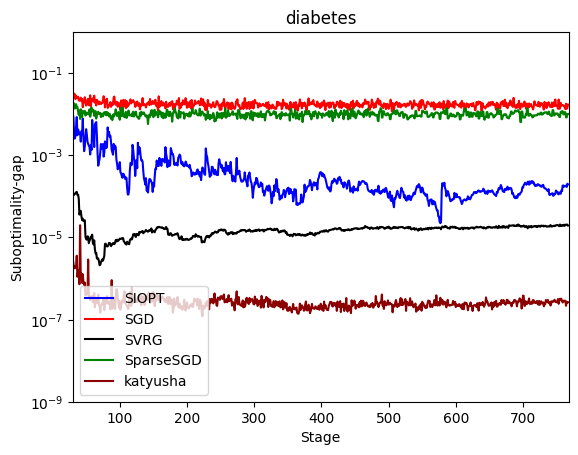

In [58]:
plot_runs(Eval_sioptruns,Eval_sgdruns,Eval_ssgdruns,Eval_svrgruns,Eval_katyusharuns,True,False,filename,True,True)

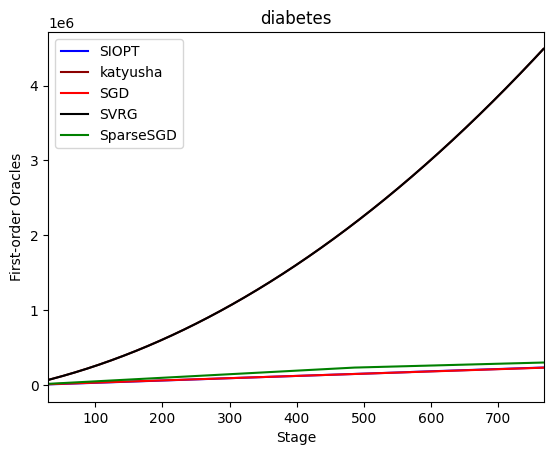

In [59]:
plot_fos(Siopt_FOs,Sgd_FOs,SSgd_FOs,SVRG_FOs,katyushas_FOs,filename,True)